# CNA GHCNh Investigation

Look at trends in the Global Historical Climatology Network hourly (GHCNh) database for the Central US.

In [1]:
import sys
import os
sys.path.append('../')
from setup import CWD, SCRATCH_DIR, FIG_DIR, DATA_DIR

import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from rich import print

def add_latlon(ax):
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}

Load data. Remember times are in Central Standard Time (CST, -6 UTC). If there are multiple hourly measurements, we leave them be. 

Many stations only record precip data so the number of wind speed stations is far less than the number of potential stations.

In [2]:
GHCNh_file = os.path.join(SCRATCH_DIR, 'GHCNh_cna.parquet')
schema = {
    'Station_ID': pl.String,
    'Station_name': pl.String,
    'time': pl.Datetime(),
    'wind_speed': pl.Float32,
    'wind_direction': pl.Float32,
    'Latitude': pl.Float32,
    'Longitude': pl.Float32,
}
df = (
    pl.scan_parquet(GHCNh_file, schema=schema)
    # Only want full years
    .filter(pl.col('time').dt.year() >= 1979)
    .filter(pl.col('time').dt.year() <= 2024)
    .sort('time')
    # .group_by_dynamic('time', every='1h').agg([
    #     pl.col(['Station_ID', 'Station_name', 'Latitude', 'Longitude']).first(),
    #     pl.col(['wind_speed', 'wind_direction']).mean(),
    # ])
)
metadata = df.select(['Station_ID', 'Station_name', 'Latitude', 'Longitude']).unique().collect()

# Some stations have wrong metadata, manually go in and fix
metadata = metadata.with_columns(
    # Schriever Air Force Base, CO
    Longitude=pl.when(pl.col('Longitude') == -121.1).then(-104.5).otherwise(pl.col('Longitude'))
)
metadata

Station_ID,Station_name,Latitude,Longitude
str,str,f32,f32
"""USI0000KH08""","""HIGH ISLAND 264C""",28.4667,-93.733299
"""USW00093911""","""SHAWNEE MUNI AP""",35.356701,-96.943298
"""USW00094037""","""BUFFALO (ASOS)""",45.604198,-103.546898
"""USW00004931""","""GLENWOOD MUNI AP""",45.643902,-95.320297
"""USW00094949""","""HASTINGS MUNI AP""",40.6003,-98.426399
…,…,…,…
"""USW00053931""","""KAISER AP""",38.096401,-92.553101
"""MXM00076390""","""SALTILLO COAH.""",25.366699,-101.016701
"""USW00053932""","""ATOKA MUNI AP""",34.3983,-96.148102


## Plot total number of samples by year

Realistically should put this plot after I have a final dataset

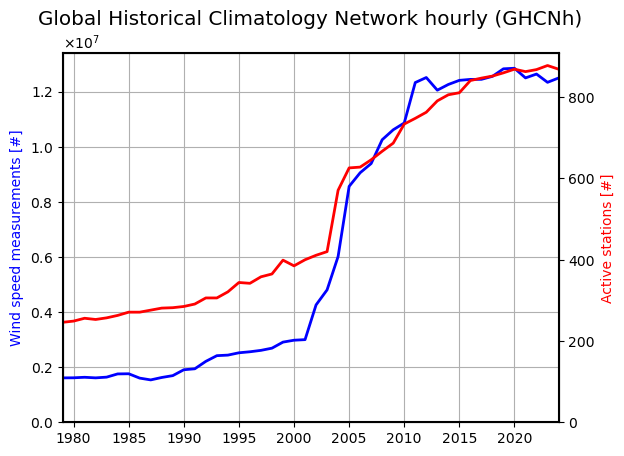

In [104]:
fig, ax = plt.subplots()
# year_samples = df.group_by_dynamic('time', every='1y').agg(records=pl.col('wind_speed').len()).collect()
# stations_per_year = df.group_by_dynamic('time', every='1y').agg(records=pl.col('Station_ID').unique().len()).collect()

ax.plot(year_samples['time'], year_samples['records'], color='b', lw=2)
ax.grid()
ax.set_ylim(0, None)
ax.set_xlim(year_samples['time'][0], year_samples['time'][-1])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_ylabel('Wind speed measurements [#]', color='b')
ax.set_title('Global Historical Climatology Network hourly (GHCNh)', fontsize='x-large')

ax2 = ax.twinx()
ax2.plot(stations_per_year['time'], stations_per_year['records'], color='r', lw=2)
ax2.set_ylabel('Active stations [#]', color='r')
ax2.set_ylim(0, None)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

plt.savefig(os.path.join(FIG_DIR, 'GHCNh_number_of_raw_records.png'), dpi=300)
plt.show()

## Filter dataframe to stations with a consistent record
To count as a valid day: `>= 4 measurements`

To count as a valid month: `>= 14 valid days`

To count as a valid year: `12 valid months`

In [56]:
good_years = (
    df
    .group_by_dynamic('time', every='1d', group_by='Station_ID')
    .agg(day_obs=pl.col('wind_speed').len())
    .filter(pl.col('day_obs') >= 4) # remove bad days
    # Cascade into months
    .group_by_dynamic('time', every='1mo', group_by='Station_ID')
    .agg(month_obs=pl.col('day_obs').len())
    .filter(pl.col('month_obs') >= 14) # remove bad months
    # Cascade into years
    .group_by_dynamic('time', every='1y', group_by='Station_ID')
    .agg(year_obs=pl.col('month_obs').len())
    .filter(pl.col('year_obs') == 12) # remove bad years
    .collect()
)
# Now get the number of active years
valid_stations = (
    good_years
    .group_by('Station_ID')
    .agg(num_years=pl.col('year_obs').len())
    .filter(pl.col('num_years') == 46) # 46 is 1979-2024
    .sort(pl.col('num_years'))
)
# Get the total number of records for each station
records_per = df.group_by('Station_ID').agg(num_obs=pl.col('wind_speed').len()).collect()
records_per_year = df.group_by_dynamic('time', every='1y', group_by='Station_ID').agg(num_obs=pl.col('wind_speed').len()).collect()

# Join with the station data
valid_stations = valid_stations.join(records_per, how='left', on='Station_ID')
good_years = (
    good_years
    .filter(pl.col('Station_ID').is_in(valid_stations['Station_ID'].to_numpy()))
    .join(records_per_year, how='left', on=['Station_ID', 'time'])
)

print('good_years', good_years.head()) # has yearly stats
print('valid_stations', valid_stations.head()) # has summary stats
print(f'Number of valid stations: {len(valid_stations)}')

good_years shape: (5, 4)
┌─────────────┬─────────────────────┬──────────┬─────────┐
│ Station_ID  ┆ time                ┆ year_obs ┆ num_obs │
│ ---         ┆ ---                 ┆ ---      ┆ ---     │
│ str         ┆ datetime[μs]        ┆ u32      ┆ u32     │
╞═════════════╪═════════════════════╪══════════╪═════════╡
│ CAM00071843 ┆ 2004-01-01 00:00:00 ┆ 12       ┆ 8424    │
│ CAM00071843 ┆ 2005-01-01 00:00:00 ┆ 12       ┆ 8550    │
│ CAM00071843 ┆ 2006-01-01 00:00:00 ┆ 12       ┆ 8541    │
│ CAM00071843 ┆ 2007-01-01 00:00:00 ┆ 12       ┆ 8545    │
│ CAM00071843 ┆ 2008-01-01 00:00:00 ┆ 12       ┆ 8605    │
└─────────────┴─────────────────────┴──────────┴─────────┘

valid_stations shape: (5, 3)
┌─────────────┬───────────┬─────────┐
│ Station_ID  ┆ num_years ┆ num_obs │
│ ---         ┆ ---       ┆ ---     │
│ str         ┆ u32       ┆ u32     │
╞═════════════╪═══════════╪═════════╡
│ USW00013919 ┆ 46        ┆ 540227  │
│ USW00013995 ┆ 46        ┆ 482645  │
│ USW00013944 ┆ 46        ┆ 474724  │
│ USW00003938 ┆ 46        ┆ 401166  │
│ USW00014919 ┆ 46        ┆ 501282  │
└─────────────┴───────────┴─────────┘

Number of valid stations: 118

### Plot this

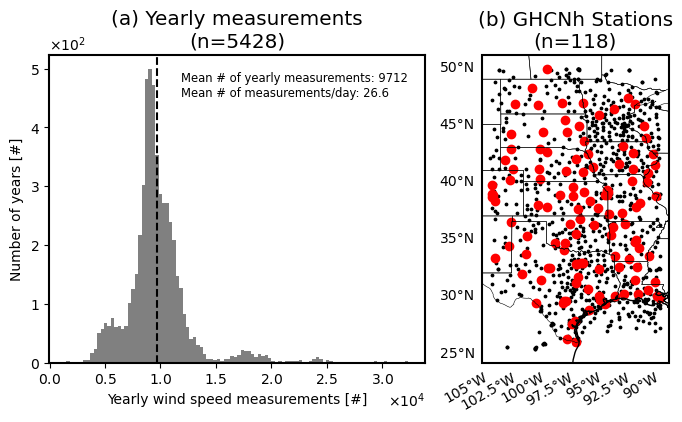

In [107]:
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(ncols=2, width_ratios=[2,1])

# Plot 1: Years of Valid Record
ax = fig.add_subplot(gs[0])
ax.hist(good_years['num_obs'], bins=100, color='gray')
mean_obs = int(good_years['num_obs'].mean())
ax.axvline(mean_obs, color='k', linestyle='dashed')
txt = f'Mean # of yearly measurements: {mean_obs}\nMean # of measurements/day: {round(mean_obs/365, 1)}'
ax.text(0.35, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.set_xlabel('Yearly wind speed measurements [#]')
ax.set_ylabel('Number of years [#]')
ax.set_title(f'(a) Yearly measurements\n(n={len(good_years)})', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Plot all stations then selected stations
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.scatter(metadata['Longitude'], metadata['Latitude'], transform=ccrs.PlateCarree(), c='k', s=3)
metadata_filtered = metadata.filter(pl.col('Station_ID').is_in(valid_stations['Station_ID'].to_numpy()))
ax.scatter(metadata_filtered['Longitude'], metadata_filtered['Latitude'], transform=ccrs.PlateCarree(), c='r')
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
add_latlon(ax)
ax.set_title(f'(b) GHCNh Stations\n(n={len(metadata_filtered)})', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_valid_stations.png'), dpi=300)
plt.show()

## Look at mean trends

In [108]:
good_IDs = valid_stations['Station_ID'].to_numpy()

### Function to reduce data to monthly given variable numbers of daily measurements

In [130]:
def make_monthly(df, good_IDs):
    agg_spec = [
            pl.col(['wind_speed', 'wind_direction']).mean(),
        ]
        # Define a function to map month to season
    def month_to_season(month):
        if month in [12, 1, 2]:
            return "DJF"  # Winter
        elif month in [3, 4, 5]:
            return "MAM"  # Spring
        elif month in [6, 7, 8]:
            return "JJA"  # Summer
        else:
            return "SON"  # Autumn
    new_df = (
        df
        .filter(pl.col('Station_ID').is_in(good_IDs))
        # Want to get monthly average on a per station basis
        .group_by_dynamic('time', every='1d', group_by='Station_ID').agg(agg_spec)
        .group_by_dynamic('time', every='1mo', group_by='Station_ID').agg(agg_spec)
        .with_columns([
            pl.col('time').dt.month().map_elements(month_to_season).alias('season')
        ])
        .sort('time')
    )
    return new_df

df_mo = make_monthly(df, good_IDs).collect()
df_mo

/tmp/ipykernel_2388154/65433112.py:27: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_mo = make_monthly(df, good_IDs).collect()


Station_ID,time,wind_speed,wind_direction,season
str,datetime[μs],f32,f32,str
"""CAN05010481""",1979-01-01 00:00:00,4.040845,22.642473,"""DJF"""
"""USI0000KBRO""",1979-01-01 00:00:00,5.194558,210.293991,"""DJF"""
"""USI0000KLCH""",1979-01-01 00:00:00,5.046513,192.961014,"""DJF"""
"""USW00003904""",1979-01-01 00:00:00,5.090475,214.223465,"""DJF"""
"""USW00003919""",1979-01-01 00:00:00,5.617447,231.966278,"""DJF"""
…,…,…,…,…
"""USW00094908""",2024-12-01 00:00:00,4.849837,209.08429,"""DJF"""
"""USW00094910""",2024-12-01 00:00:00,4.690849,220.911713,"""DJF"""
"""USW00094931""",2024-12-01 00:00:00,3.856548,240.996246,"""DJF"""


Slope (per decade): -0.03

R2: 0.13

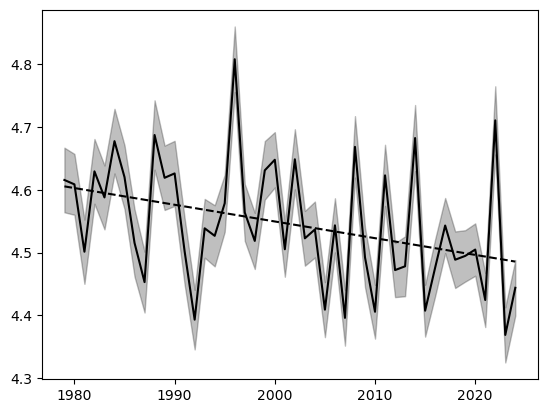

In [160]:
from sklearn.linear_model import LinearRegression

yearly = df_mo.group_by_dynamic('time', every='1y').agg([
    pl.col('wind_speed').mean().alias('wind_mean'),
    (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
])
fig, ax = plt.subplots()
x = yearly['time'].dt.year().to_numpy()
y = yearly['wind_mean'].to_numpy()
# y = y-np.mean(y[:5])
err = yearly['wind_stderr'].to_numpy()*1.96 # z-score
ax.plot(x, y, color='k')
ax.fill_between(x, y-err, y+err, color='k', alpha=0.25)
# regress
xx = x.reshape(-1, 1)
reg = LinearRegression().fit(xx, y)
ax.plot(x, reg.predict(xx), color='k', linestyle='dashed')
print(f'Slope (per decade): {round(reg.coef_[0]*10, 2)}')
print(f'R2: {round(reg.score(xx, y), 2)}')

plt.show()

DJF

Slope (per decade): -0.03

R2: 0.04

MAM

Slope (per decade): -0.01

R2: 0.0

JJA

Slope (per decade): -0.02

R2: 0.05

SON

Slope (per decade): -0.05

R2: 0.3

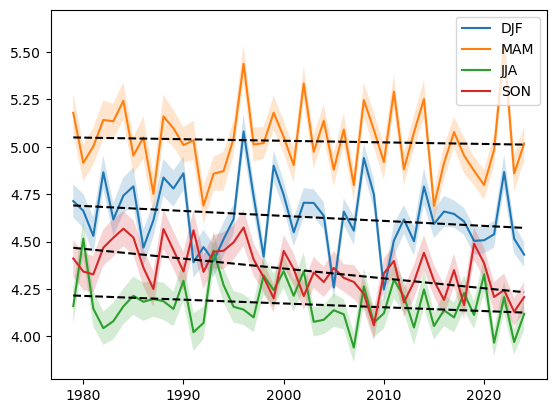

In [158]:
fig, ax = plt.subplots()
for season in ['DJF', 'MAM', 'JJA', 'SON']:
    s_yearly = (
        df_mo
        .filter(pl.col('season') == season)
        .group_by_dynamic('time', every='1y').agg([
            pl.col('wind_speed').mean().alias('wind_mean'),
            (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
        ])
    )
    x = s_yearly['time'].dt.year().to_numpy()
    y = s_yearly['wind_mean'].to_numpy()
    # y = y-np.mean(y)
    err = s_yearly['wind_stderr'].to_numpy()*1.96 # z-score
    ax.plot(x, y, label=season)
    ax.fill_between(x, y-err, y+err, alpha=0.2)
    # regress
    xx = x.reshape(-1, 1)
    reg = LinearRegression().fit(xx, y)
    ax.plot(x, reg.predict(xx), color='k', linestyle='dashed')
    print(season)
    print(f'\tSlope (per decade): {round(reg.coef_[0]*10, 2)}')
    print(f'\tR2: {round(reg.score(xx, y), 2)}')
ax.legend()
plt.show()

### Split into daytime and nocturnal

Day is `[06, 18)`, night is `[18, 06]` (recall this data is in CST). Filter by day because night goes till the next day so it gets tricky.

In [ ]:
df_diurnal = (
    df
    .filter(pl.col('Station_ID') == 'USW00012920')
    .with_columns(
        day = (pl.col('time').dt.hour() >= 6) & (pl.col('time').dt.hour() < 18)
    )
)

df_day = make_monthly(df_diurnal.filter(pl.col('day') == True))
df_night = make_monthly(df_diurnal.filter(pl.col('day') != True))

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_day['time'], df_day['wind_speed'])
ax.scatter(df_night['time'], df_night['wind_speed'])
ax.grid()
ax.set_ylim(0, None)

plt.show()

In [ ]:
# Need to get same months
same_months_day = df_day.filter(pl.col('time').is_in(same_months_night['time']))
same_months_night = df_night.filter(pl.col('time').is_in(df_day['time']))
fig, ax = plt.subplots()
ax.scatter(same_months_night['time'], same_months_day['wind_speed']-same_months_night['wind_speed'])
ax.grid()
ax.set_ylim(0, None)
ax.set_title('Day - Night')
plt.show()